# 1- PDF sampling

## All PDFS

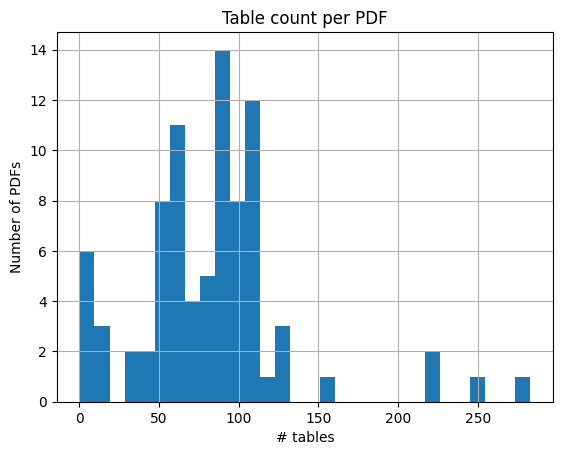

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

ABS_PATH = 'path/to/your/absolute/directory'  # Replace with your actual path
df = pd.read_csv(f"{ABS_PATH}/tablequest/metadata/table_counts_by_doc.csv")
df["table_count"].hist(bins=30)
plt.title("Table count per PDF")
plt.xlabel("# tables")
plt.ylabel("Number of PDFs")
plt.show()

In [15]:
df.shape

(84, 5)

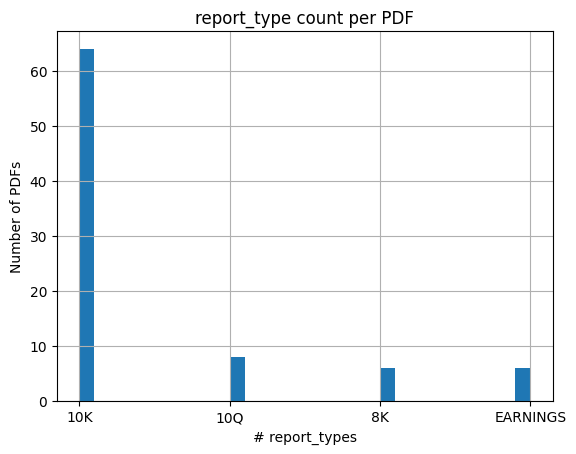

In [2]:
df["report_type"].hist(bins=30)
plt.title("report_type count per PDF")
plt.xlabel("# report_types")
plt.ylabel("Number of PDFs")
plt.show()

In [3]:
df["report_type"].value_counts()

report_type
10K         64
10Q          8
8K           6
EARNINGS     6
Name: count, dtype: int64

In [4]:
df["company_name"].value_counts()

company_name
MGMRESORTS              5
ADOBE                   4
NIKE                    4
AMCOR                   4
JPMORGAN                4
BESTBUY                 4
3M                      3
COCACOLA                3
PEPSICO                 3
LOCKHEEDMARTIN          3
JOHNSON_JOHNSON         3
GENERALMILLS            3
CORNING                 3
WALMART                 3
AMERICANWATERWORKS      3
BOEING                  2
CVSHEALTH               2
VERIZON                 2
ULTABEAUTY              2
BLOCK                   2
PEPSICO_2023            2
AMD                     2
MICROSOFT               2
NETFLIX                 2
AMAZON                  2
PAYPAL                  1
Pfizer                  1
PFIZER                  1
AES                     1
AMCOR_2022              1
COSTCO                  1
KRAFTHEINZ              1
AMERICANEXPRESS         1
JOHNSON_JOHNSON_2023    1
ACTIVISIONBLIZZARD      1
FOOTLOCKER_2022         1
FOOTLOCKER_2022_8K      1
Name: count, dtype: int64

## Sample PDFs if needed 

In [5]:
df.head()

,document_name,company_name,report_type,report_year,table_count
0,3M_2018_10K,3M,10K,2018,95
1,3M_2022_10K,3M,10K,2022,102
2,3M_2023Q2_10Q,3M,10Q,2023Q2,66
3,ACTIVISIONBLIZZARD_2019_10K,ACTIVISIONBLIZZARD,10K,2019,91
4,ADOBE_2015_10K,ADOBE,10K,2015,85


In [6]:
df['report_type'].unique()

array(['10K', '10Q', '8K', 'EARNINGS'], dtype=object)

In [7]:
df['report_type'].value_counts()

report_type
10K         64
10Q          8
8K           6
EARNINGS     6
Name: count, dtype: int64

In [54]:
12+16

28

In [8]:
df.groupby('report_type')['table_count'].describe()

,count,mean,std,min,25%,50%,75%,max
report_type,,,,,,,,
10K,64.0,91.296875,33.265970,50.0,69.75,90.0,105.5,283.0
10Q,8.0,119.625000,93.856939,38.0,49.75,62.0,221.0,252.0
8K,6.0,7.666667,11.290114,0.0,1.50,3.5,7.0,30.0
EARNINGS,6.0,20.333333,11.843423,8.0,13.50,15.5,28.0,38.0


In [9]:
df[df["report_type"] == '10K']["table_count"].median()
# median_val = filtered["table_count"].median()


90.0

In [10]:
import random

random.seed(42)
median = df[df["report_type"] == '10K']["table_count"].median()
filtered_10k =  df[(df['report_type'] == '10K') & (df['table_count'] >= median)]
print(filtered_10k.shape)

sample_10k = filtered_10k.sample(8, random_state=42)
print(sample_10k.shape)


(32, 5)
(8, 5)


In [11]:
sample_10k['company_name'].unique()

array(['VERIZON', 'COCACOLA', 'JOHNSON_JOHNSON', 'CORNING',
       'AMERICANWATERWORKS', 'BESTBUY', 'JPMORGAN'], dtype=object)

# 2- Filter for each question type

In [ ]:
# replace "UnkwownType" with "8K"
import pandas as pd
import numpy as np

all_pages_df = pd.read_csv(f"{ABS_PATH}/tablequest/metadata/all_extracted_pages_metadata.csv")
all_pages_df['report_type'] = all_pages_df['report_type'].replace('UnknownType', '8K')
all_pages_df.to_csv(f"{ABS_PATH}/tablequest/metadata/all_extracted_pages_metadata.csv", index=False)

In [18]:
all_pages_df.shape

(4679, 7)

In [17]:
all_pages_df['table_count'].describe()

count    4679.000000
mean        1.489207
std         0.798567
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: table_count, dtype: float64

In [ ]:
all_pages_df = pd.read_csv(f"{ABS_PATH}/tablequest/metadata/all_extracted_pages_metadata.csv")
print(all_pages_df.shape)

easy_medium_df = all_pages_df[all_pages_df['table_count'] == 1]
easy_medium_df.to_csv(f'{ABS_PATH}/tablequest/metadata/tablequest_easy_medium.csv', index=False)
print(easy_medium_df.shape)
hard_df = all_pages_df[all_pages_df['table_count'] > 1]
print(hard_df.shape)

(4679, 7)
(3061, 7)
(1618, 7)


In [61]:
easy_medium_df.head(1)

,document_path,document_name,company_name,report_type,report_year,page_number,table_count
0,financebench/CORNING_2022_10K.pdf,CORNING_2022_10K,CORNING,10K,2022,1,1


### Hard sample

In [62]:
import pandas as pd
import numpy as np

def quota_sample(df: pd.DataFrame,
                 strat_col: str,
                 total: int,
                 random_state: int | None = None) -> pd.DataFrame:
    """
    Stratified sample with “fair-quota” allocation.
    
    • Guarantees `total` rows in the result (if enough rows exist).  
    • Allocates rows across the categories in **strat_col** so that  
      – no category is asked for more than it owns,  
      – leftover quota is distributed as evenly as possible.
    
    Parameters
    ----------
    df : DataFrame
    strat_col : str          column to stratify on
    total : int              total rows to sample
    random_state : int/None  reproducibility seed
    
    Returns
    -------
    DataFrame  — sampled rows
    """
    counts = df[strat_col].value_counts().to_dict()
    if total > len(df):
        raise ValueError("`total` exceeds DataFrame length")
    
    remaining = total
    quotas: dict[str, int] = {}
    remaining_types = set(counts)

    while remaining_types:
        k = len(remaining_types)
        q = remaining // k  # provisional equal share
        all_big = True
        for t in list(remaining_types):
            if counts[t] <= q:         # give small buckets all they have
                quotas[t] = counts[t]
                remaining -= counts[t]
                remaining_types.remove(t)
                all_big = False
        if all_big:                    # everyone still bigger than q → lock in q
            for t in remaining_types:
                quotas[t] = q
                remaining -= q
            break                      # quotas fixed

    # hand out any leftover one-by-one
    for t in list(quotas)[:remaining]:
        quotas[t] += 1

    rng = np.random.default_rng(random_state)
    parts = [
        df[df[strat_col] == t].sample(n=quotas[t],
                                      replace=False,
                                      random_state=rng.integers(1e9))
        for t in quotas
    ]
    return pd.concat(parts).reset_index(drop=True)

# -----------------------------------------------------------------
# Example usage
hard_sample = quota_sample(hard_df, "report_type", 70, random_state=42)
print(hard_sample["report_type"].value_counts())
print("Total sampled:", len(hard_sample))

report_type
10Q         21
EARNINGS    21
10K         21
8K           7
Name: count, dtype: int64
Total sampled: 70


In [63]:
hard_sample.iloc[50]

document_path    financebench/BOEING_2022_10K.pdf
document_name                     BOEING_2022_10K
company_name                               BOEING
report_type                                   10K
report_year                                  2022
page_number                                    24
table_count                                     2
Name: 50, dtype: object

In [64]:
all_pages_df['report_type'].value_counts()

report_type
10K         3937
10Q          624
EARNINGS      81
8K            37
Name: count, dtype: int64

### Easy & Medium

count    2970.000000
mean       73.574074
std        73.341802
min         0.000000
25%        20.000000
50%        48.000000
75%       100.000000
max       484.000000
Name: min_cells, dtype: float64


<Axes: >

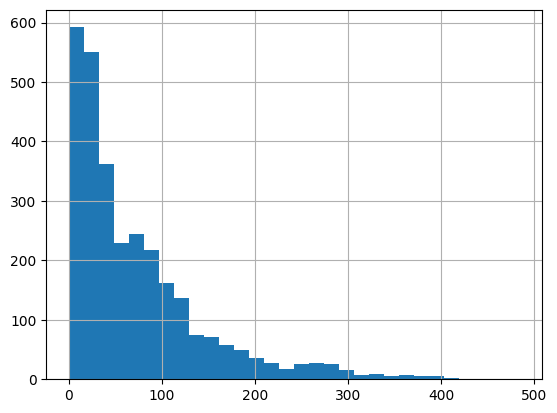

In [ ]:
import pandas as pd 

enriched_easy_medium_df = pd.read_csv(f'{ABS_PATH}/tablequest/metadata/tablequest_easy_medium_enriched.csv')
print(enriched_easy_medium_df['min_cells'].describe())
enriched_easy_medium_df['min_cells'].hist(bins=30)


In [66]:
enriched_easy_medium_df['table_count'].unique()

array([1])

In [67]:
easy_df = enriched_easy_medium_df[(enriched_easy_medium_df['min_cells'] > 5) & (enriched_easy_medium_df['min_cells'] <= 10)]
easy_df.shape

(218, 9)

In [68]:
easy_df.iloc[12]

document_path                        financebench/AMCOR_2020_10K.pdf
document_name                                         AMCOR_2020_10K
company_name                                                   AMCOR
report_type                                                      10K
report_year                                                     2020
page_number                                                       29
table_count                                                        1
tables_markdown    | (in millions)                               ...
min_cells                                                        6.0
Name: 136, dtype: object

In [69]:
easy_sample = quota_sample(easy_df, "report_type", 70, random_state=42)
print(easy_sample["report_type"].value_counts())
print("Total sampled:", len(easy_sample))

report_type
10K         47
10Q         20
EARNINGS     2
8K           1
Name: count, dtype: int64
Total sampled: 70


In [70]:
medium_sample = enriched_easy_medium_df[(enriched_easy_medium_df['min_cells'] > 50) & (enriched_easy_medium_df['min_cells'] <= 100)]
medium_sample.shape

(706, 9)

In [71]:
medium_sample.iloc[123]

document_path                          financebench/AES_2022_10K.pdf
document_name                                           AES_2022_10K
company_name                                                     AES
report_type                                                      10K
report_year                                                     2022
page_number                                                      249
table_count                                                        1
tables_markdown    | Ventos de Santa Tereza 02 Energias Renovávei...
min_cells                                                       92.0
Name: 461, dtype: object

In [72]:
medium_sample = quota_sample(medium_sample, "report_type", 70, random_state=42)
print(medium_sample["report_type"].value_counts())
print("Total sampled:", len(medium_sample))

report_type
10Q         28
10K         28
EARNINGS    12
8K           2
Name: count, dtype: int64
Total sampled: 70


### Dispaly filtered pages

In [73]:
df.head(1)

,document_name,company_name,report_type,report_year,table_count
0,3M_2018_10K,3M,10K,2018,95


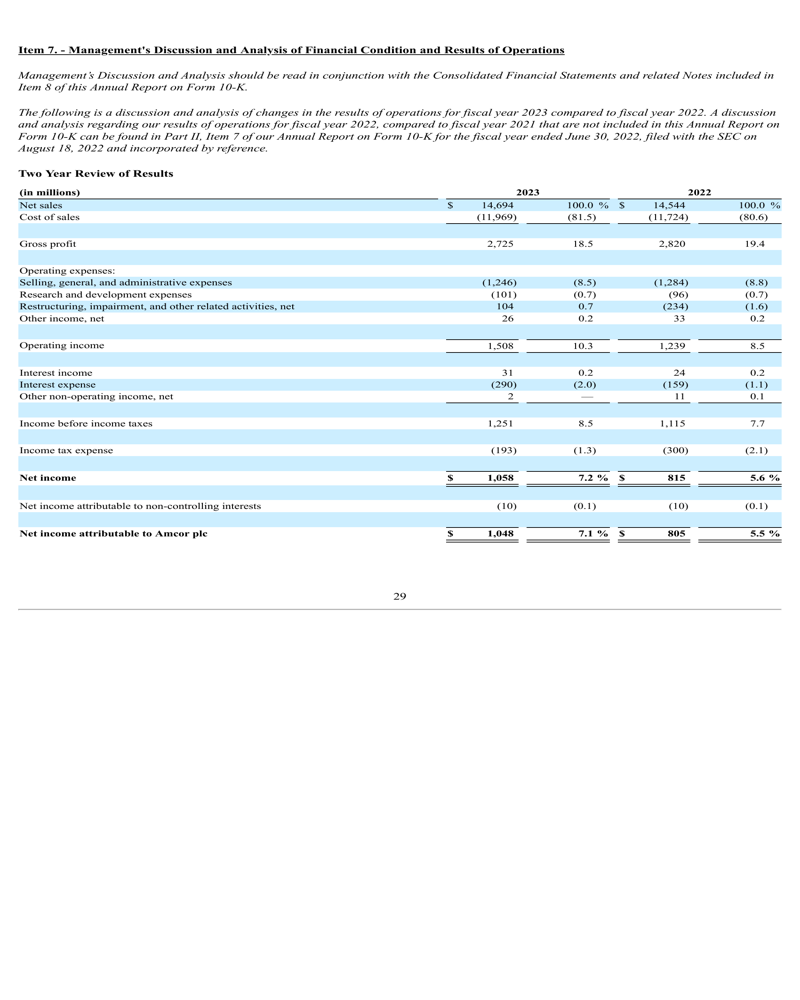

In [ ]:
from pdf2image import convert_from_path
from IPython.display import display
from pathlib import Path


def show_random_pdf_pages(df, n=5, base_path=f"{ABS_PATH}", size=(800, 1000)):
    base = Path(base_path).resolve()
    samples = df.sample(n)
    for _, row in samples.iterrows():
        pdf_path = base / row["document_path"]
        page_num = int(row["page_number"])
        try:
            image = convert_from_path(str(pdf_path), dpi=200, first_page=page_num, last_page=page_num)[0]
            image = image.resize(size)
            display(image)
        except Exception as e:
            print(f"[Error] {pdf_path} page {page_num}: {e}")

show_random_pdf_pages(medium_sample,
                      n=1)


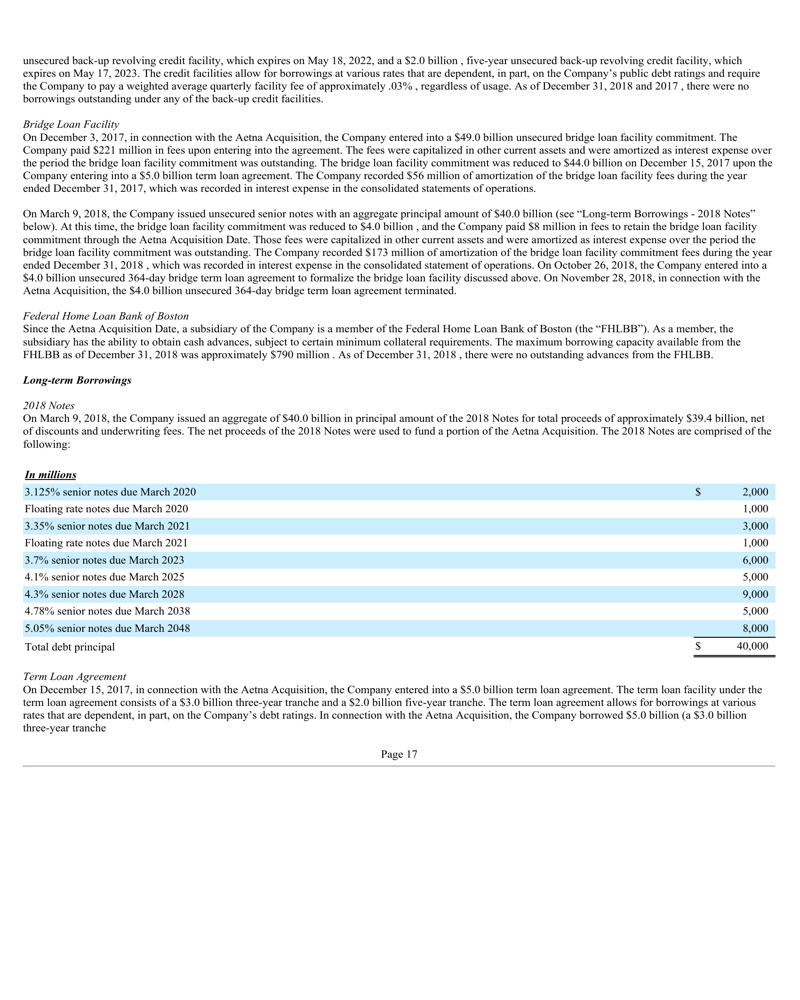

In [75]:
show_random_pdf_pages(enriched_easy_medium_df[(enriched_easy_medium_df['min_cells'] > 10) & (enriched_easy_medium_df['min_cells'] <= 25)],
                      n=1)

## Save filtered pages

In [ ]:
from pathlib import Path
from pdf2image import convert_from_path

def save_pdf_pages(df, base_path=f"{ABS_PATH}", dpi=200, type='easy'):
    output_dir = Path(f"{ABS_PATH}/tablequest/sampled_pages") / type
    output_dir.mkdir(parents=True, exist_ok=True)

    total = len(df)
    for i, row in enumerate(df.itertuples(index=False), 1):
        pdf_path = Path(base_path) / row.document_path
        page_num = int(row.page_number)
        try:
            print(f"[{i}/{total}] Saving {row.document_name} page {page_num}...")
            image = convert_from_path(str(pdf_path), dpi=dpi, first_page=page_num, last_page=page_num)[0]
            filename = f"{Path(row.document_name).stem}_p{page_num}.png"
            image.save(output_dir / filename, "PNG")
        except Exception as e:
            print(f"[Error] {pdf_path} page {page_num}: {e}")

In [77]:
# save_pdf_pages(hard_sample, dpi=200, type='hard')

In [78]:
# save_pdf_pages(medium_sample, dpi=200, type='medium')

In [79]:
# save_pdf_pages(easy_sample, dpi=200, type='easy')

In [80]:
hard_sample

,document_path,document_name,company_name,report_type,report_year,page_number,table_count
0,financebench/JOHNSON-JOHNSON_2023_8K_dated-202...,JOHNSON-JOHNSON_2023_8K_dated-2023-08-30,JOHNSON-JOHNSON_2023,8K,8K,19,2
1,financebench/JOHNSON-JOHNSON_2023_8K_dated-202...,JOHNSON-JOHNSON_2023_8K_dated-2023-08-30,JOHNSON-JOHNSON_2023,8K,8K,24,2
2,financebench/JOHNSON-JOHNSON_2023_8K_dated-202...,JOHNSON-JOHNSON_2023_8K_dated-2023-08-30,JOHNSON-JOHNSON_2023,8K,8K,5,3
3,financebench/PEPSICO_2023_8K_dated-2023-05-05.pdf,PEPSICO_2023_8K_dated-2023-05-05,PEPSICO_2023,8K,8K,4,2
4,financebench/JOHNSON-JOHNSON_2023_8K_dated-202...,JOHNSON-JOHNSON_2023_8K_dated-2023-08-30,JOHNSON-JOHNSON_2023,8K,8K,23,2
...,...,...,...,...,...,...,...
65,financebench/LOCKHEEDMARTIN_2022_10K.pdf,LOCKHEEDMARTIN_2022_10K,LOCKHEEDMARTIN,10K,2022,83,2
66,financebench/ACTIVISIONBLIZZARD_2019_10K.pdf,ACTIVISIONBLIZZARD_2019_10K,ACTIVISIONBLIZZARD,10K,2019,109,2
67,financebench/WALMART_2019_10K.pdf,WALMART_2019_10K,WALMART,10K,2019,62,3
68,financebench/AMD_2022_10K.pdf,AMD_2022_10K,AMD,10K,2022,79,2


## Save samples as csv

In [ ]:
# Drop unwanted columns before saving
easy_sample.drop(columns=["tables_markdown", "min_cells"], inplace=True)
easy_sample.to_csv(f'{ABS_PATH}/tablequest/metadata/final_samples/sampled_easy.csv', index=False)

medium_sample.drop(columns=["tables_markdown", "min_cells"], inplace=True)
medium_sample.to_csv(f'{ABS_PATH}/tablequest/metadata/final_samples/sampled_medium.csv', index=False)

hard_sample.to_csv(f'{ABS_PATH}/tablequest/metadata/final_samples/sampled_hard.csv', index=False)

# Stats

In [ ]:
import pandas as pd

easy_sample_df = pd.read_csv(f'{ABS_PATH}/tablequest/metadata/final_samples/sampled_easy.csv')
medium_sample_df = pd.read_csv(f'{ABS_PATH}/tablequest/metadata/final_samples/sampled_medium.csv')
hard_sample_df = pd.read_csv(f'{ABS_PATH}/tablequest/metadata/final_samples/sampled_hard.csv')

print("Easy sample unique document_name:", easy_sample_df["document_name"].nunique())
print("Medium sample unique document_name:", medium_sample_df["document_name"].nunique())
print("Hard sample unique document_name:", hard_sample_df["document_name"].nunique())

all_doc_names = pd.concat([
    easy_sample_df["document_name"],
    medium_sample_df["document_name"],
    hard_sample_df["document_name"]
]).unique()
print("Total unique document_name (union):", len(all_doc_names))

Easy sample unique document_name: 43
Medium sample unique document_name: 37
Hard sample unique document_name: 33
Total unique document_name (union): 66


In [ ]:
from pathlib import Path
import re

def get_doc_names(folder):
    files = [f for f in Path(folder).iterdir() if f.suffix == '.png']
    doc_names = set()
    for f in files:
        match = re.match(r'(.+)_p\d+\.png', f.name)
        if match:
            doc_names.add(match.group(1))
    return doc_names

base = f'{ABS_PATH}/tablequest/sampled_pages'
easy_docs = get_doc_names(f'{base}/easy')
medium_docs = get_doc_names(f'{base}/medium')
hard_docs = get_doc_names(f'{base}/hard')

print('Easy:', len(easy_docs), 'unique document names')
print('Medium:', len(medium_docs), 'unique document names')
print('Hard:', len(hard_docs), 'unique document names')
all_union = easy_docs | medium_docs | hard_docs
print('All (union):', len(all_union), 'unique document names')

Easy: 36 unique document names
Medium: 34 unique document names
Hard: 34 unique document names
All (union): 64 unique document names


In [21]:
# Filter out rows pages that aren't existing in sampled_pages/easy, medium, hard
easy_sample_df.head()

,document_path,document_name,company_name,report_type,report_year,page_number,table_count
0,financebench/JOHNSON-JOHNSON_2022Q4_EARNINGS.pdf,JOHNSON-JOHNSON_2022Q4_EARNINGS,JOHNSON-JOHNSON,EARNINGS,2022Q4,5,1
1,financebench/JOHNSON-JOHNSON_2022Q4_EARNINGS.pdf,JOHNSON-JOHNSON_2022Q4_EARNINGS,JOHNSON-JOHNSON,EARNINGS,2022Q4,1,1
2,financebench/PEPSICO_2023_8K_dated-2023-05-05.pdf,PEPSICO_2023_8K_dated-2023-05-05,PEPSICO_2023,8K,8K,3,1
3,financebench/JPMORGAN_2023Q2_10Q.pdf,JPMORGAN_2023Q2_10Q,JPMORGAN,10Q,2023Q2,161,1
4,financebench/AMCOR_2023Q2_10Q.pdf,AMCOR_2023Q2_10Q,AMCOR,10Q,2023Q2,38,1


In [16]:
easy_sample_df.shape

(62, 7)

In [14]:
hard_sample_df['table_count'].value_counts()

table_count
2    46
3    20
5     2
4     2
Name: count, dtype: int64

count    70.000000
mean      2.428571
std       0.693059
min       2.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       5.000000
Name: table_count, dtype: float64